In [ ]:
!nvidia-smi

Tue Nov 18 14:23:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install --upgrade transformers accelerate datasets evaluate -q



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 21.9 MB/s eta 0:00:00


In [ ]:
!git clone https://gitlab.com/checkthat_lab/clef2025-checkthat-lab.git
!ls clef2025-checkthat-lab/task1/data/english

Cloning into 'clef2025-checkthat-lab'...
remote: Enumerating objects: 866, done.
remote: Counting objects: 100% (845/845), done.
remote: Compressing objects: 100% (426/426), done.
remote: Total 866 (delta 413), reused 829 (delta 406), pack-reused 21 (from 1)
Receiving objects: 100% (866/866), 78.96 MiB | 11.06 MiB/s, done.
Resolving deltas: 100% (417/417), done.
Updating files: 100% (181/181), done.
dev_en.tsv	 Licenses_by-nc-sa_4.0_legalcode.txt  test_en_unlabeled.tsv
dev_test_en.tsv  test_en_labeled.tsv		      train_en.tsv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/checkthat_subj_model"

In [ ]:
import pandas as pd

train_path = "clef2025-checkthat-lab/task1/data/english/train_en.tsv"

df_head = pd.read_csv(train_path, sep="\t", nrows=5)
df_head

,sentence_id,sentence,label,solved_conflict
0,b9e1635a-72aa-467f-86d6-f56ef09f62c3,Gone are the days when they led the world in r...,SUBJ,True
1,f99b5143-70d2-494a-a2f5-c68f10d09d0a,The trend is expected to reverse as soon as ne...,OBJ,False
2,4076639c-aa56-4202-ae0f-9d9217f8da68,But there is the specious point again.,OBJ,False
3,b057c366-698e-419d-a284-9b16d835c64e,He added he wouldn’t be surprised to see a new...,OBJ,False
4,a5a9645e-7850-41ba-90a2-5def725cd5b8,"Not less government, you see; the same amount ...",SUBJ,False


In [ ]:
from datasets import load_dataset

data_files = {
    "train": "clef2025-checkthat-lab/task1/data/english/train_en.tsv",
    "validation": "clef2025-checkthat-lab/task1/data/english/dev_en.tsv",
    "dev_test": "clef2025-checkthat-lab/task1/data/english/dev_test_en.tsv",
    "test_labeled": "clef2025-checkthat-lab/task1/data/english/test_en_labeled.tsv",
    "test_unlabeled": "clef2025-checkthat-lab/task1/data/english/test_en_unlabeled.tsv",
}

checkthat = load_dataset(
    "csv",
    data_files=data_files,
    delimiter="\t",
)


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev_test split: 0 examples [00:00, ? examples/s]

Generating test_labeled split: 0 examples [00:00, ? examples/s]

Generating test_unlabeled split: 0 examples [00:00, ? examples/s]

In [ ]:
#inpeção de uma linha
checkthat["train"][0]

{'sentence_id': 'b9e1635a-72aa-467f-86d6-f56ef09f62c3',
 'sentence': 'Gone are the days when they led the world in recession-busting',
 'label': 'SUBJ',
 'solved_conflict': True}

In [ ]:
from copy import deepcopy
checkthat2 = deepcopy(checkthat)


In [ ]:
label2id = {"OBJ": 0, "SUBJ": 1}
id2label = {0: "OBJ", 1: "SUBJ"}

In [ ]:
def encode_labels(example):
    example["labels"] = label2id[example["label"]]
    return example

In [ ]:
labeled_splits = ["train", "validation", "dev_test", "test_labeled"]

for split in labeled_splits:
    checkthat2[split] = checkthat2[split].map(encode_labels)

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
cols_to_keep = ["sentence", "labels", "label"]
for split in labeled_splits:
    cols_to_remove = [c for c in checkthat2[split].column_names if c not in cols_to_keep]
    checkthat2[split] = checkthat2[split].remove_columns(cols_to_remove)

# test_unlabeled mantemos só a sentence
checkthat2["test_unlabeled"] = checkthat2["test_unlabeled"].remove_columns(
    [c for c in checkthat2["test_unlabeled"].column_names if c != "sentence"]
)

In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def tokenize_batch(example):
    return tokenizer(
        example["sentence"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

checkthat_tok = checkthat2.map(tokenize_batch, batched=True)

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
for split in labeled_splits:
    checkthat_tok[split].set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"]
    )

In [ ]:
import transformers
transformers.__version__

'4.57.1'

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

import os
os.environ["WANDB_DISABLED"] = "true"


accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

MODEL_NAME = "roberta-base"

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

training_args = TrainingArguments(
    output_dir="/content/checkthat_run",
    # sem evaluation_strategy, sem save_strategy
    learning_rate=2e-5,
    num_train_epochs=30,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=checkthat_tok["train"],
    eval_dataset=checkthat_tok["validation"],  # ainda podemos usar pra evaluate() depois
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2240831358.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.641600
100,0.466500
150,0.302100
200,0.224000
250,0.126100
300,0.084200
350,0.056900
400,0.041100
450,0.004700
500,0.007900


TrainOutput(global_step=1560, training_loss=0.06619890043336618, metrics={'train_runtime': 1087.3756, 'train_samples_per_second': 22.899, 'train_steps_per_second': 1.435, 'total_flos': 3275732639232000.0, 'train_loss': 0.06619890043336618, 'epoch': 30.0})

In [ ]:
print("VAL (dev):")
print(trainer.evaluate(checkthat_tok["validation"]))

print("\nDEV-TEST:")
print(trainer.evaluate(checkthat_tok["dev_test"]))

print("\nTEST LABELED:")
print(trainer.evaluate(checkthat_tok["test_labeled"]))


VAL (dev):


{'eval_loss': 1.865133285522461, 'eval_accuracy': 0.7835497835497836, 'eval_f1_macro': 0.7835457271364318, 'eval_runtime': 5.9259, 'eval_samples_per_second': 77.963, 'eval_steps_per_second': 2.531, 'epoch': 30.0}

DEV-TEST:
{'eval_loss': 1.6979453563690186, 'eval_accuracy': 0.8078512396694215, 'eval_f1_macro': 0.6966989427722412, 'eval_runtime': 6.1337, 'eval_samples_per_second': 78.908, 'eval_steps_per_second': 2.609, 'epoch': 30.0}

TEST LABELED:
{'eval_loss': 1.6946126222610474, 'eval_accuracy': 0.79, 'eval_f1_macro': 0.74414858334123, 'eval_runtime': 3.7931, 'eval_samples_per_second': 79.091, 'eval_steps_per_second': 2.636, 'epoch': 30.0}


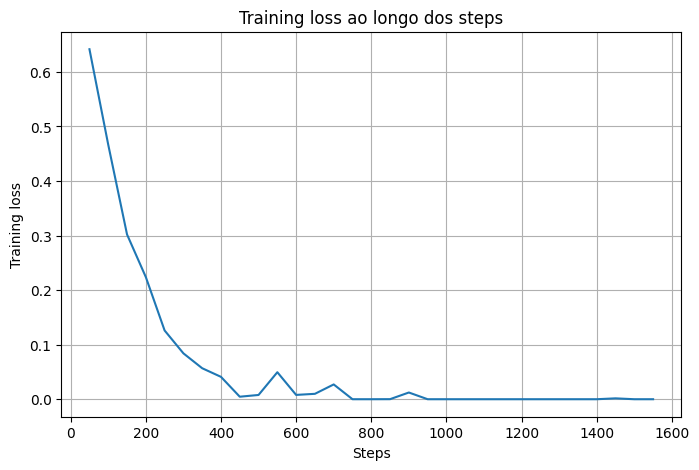

In [ ]:
import matplotlib.pyplot as plt

# pega o log do Trainer
logs = trainer.state.log_history

# filtra só entradas que têm 'loss' (treino)
train_steps = [entry["step"] for entry in logs if "loss" in entry]
train_losses = [entry["loss"] for entry in logs if "loss" in entry]

plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_losses)
plt.xlabel("Steps")
plt.ylabel("Training loss")
plt.title("Training loss ao longo dos steps")
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

def classify_subjectivity(texts, batch_size=32):
    if isinstance(texts, str):
        texts = [texts]

    results = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]

            enc = tokenizer(
                batch,
                truncation=True,
                padding=True,
                max_length=256,
                return_tensors="pt"
            ).to(device)

            logits = model(**enc).logits
            probs = F.softmax(logits, dim=-1)

            preds = torch.argmax(probs, dim=-1).cpu().tolist()
            probs_subj = probs[:, 1].cpu().tolist()

            for t, p, pr in zip(batch, preds, probs_subj):
                results.append({
                    "text": t,
                    "prediction": id2label[p],      # 'OBJ' ou 'SUBJ'
                    "prob_subj": float(pr)
                })

    return results


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
testes = [
    "The government clearly lied and this is outrageous.",
    "GDP rose 3% according to official data."
]

classify_subjectivity(testes)

[{'text': 'The government clearly lied and this is outrageous.',
  'prediction': 'SUBJ',
  'prob_subj': 0.9999631643295288},
 {'text': 'GDP rose 3% according to official data.',
  'prediction': 'OBJ',
  'prob_subj': 3.386089883861132e-05}]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

SAVE_DIR = "/content/drive/MyDrive/checkthat_subj_model"

trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print("Modelo salvo em:", SAVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo salvo em: /content/drive/MyDrive/checkthat_subj_model


Segunda Task


In [ ]:
!git clone https://github.com/NUSTM/SemEval-2024_ECAC.git
!ls SemEval-2024_ECAC/data


Cloning into 'SemEval-2024_ECAC'...
remote: Internal Server Error
fatal: unable to access 'https://github.com/NUSTM/SemEval-2024_ECAC.git/': The requested URL returned error: 500
ls: cannot access 'SemEval-2024_ECAC/data': No such file or directory


In [ ]:
import json

train_path = "SemEval-2024_ECAC/data/Subtask_1_train.json"
test_path  = "SemEval-2024_ECAC/data/Subtask_1_test.json"

with open(train_path, "r") as f:
    sub1_train = json.load(f)

with open(test_path, "r") as f:
    sub1_test = json.load(f)

len(sub1_train), len(sub1_test), sub1_train[0]


FileNotFoundError: [Errno 2] No such file or directory: 'SemEval-2024_ECAC/data/Subtask_1_train.json'

In [ ]:
def build_context(utterances):
    """
    utterances: lista de dicts com campos tipo:
      - 'speaker'
      - 'text'
      - 'utterance_ID'
    Saída: string com linhas:
      U1_Rachel: bla bla
      U2_Ross: foo bar
    """
    lines = []
    for idx, utt in enumerate(utterances):
        spk = utt.get("speaker", f"Speaker{idx+1}")
        txt = utt["text"]
        lines.append(f"U{utt['utterance_ID']}_{spk}: {txt}")
    return "\n".join(lines)


In [ ]:
def conversation_to_qa_examples(conv_item):
    """
    conv_item: um elemento de sub1_train/sub1_test

    Esperado:
      conv_item["conversation_ID"]
      conv_item["conversation"] -> lista de falas
      conv_item["emotion-cause_pairs"] -> lista de pares [ emo_tag, cause_tag ]

    Onde:
      emo_tag   = "3_surprise"
      cause_tag = "1_I realize I am totally naked ."
    """
    conv_id = conv_item["conversation_ID"]
    utterances = conv_item["conversation"]
    pairs = conv_item["emotion-cause_pairs"]

    context = build_context(utterances)
    qa_examples = []

    for emo_tag, cause_tag in pairs:
        # emo_tag = "3_surprise"
        emo_utt_id_str, emotion = emo_tag.split("_", 1)

        # cause_tag = "1_I realize I am totally naked ."
        cause_utt_id_str, cause_span = cause_tag.split("_", 1)

        question = f"What is the cause of the emotion {emotion}?"

        # encontrar o span da causa dentro do context
        start_char = context.find(cause_span)
        if start_char == -1:
            # fallback: se não achar o span exato, pula (pode contar quantos pulou)
            # você pode logar isso depois se quiser debug
            continue

        qa_examples.append({
            "id": f"{conv_id}_{emo_tag}_{cause_utt_id_str}",
            "context": context,
            "question": question,
            "answers": {
                "text": [cause_span],
                "answer_start": [start_char],
            },
            "emotion": emotion,
            "conversation_ID": conv_id,
        })

    return qa_examples


In [ ]:
qa_train = []
for item in sub1_train:
    qa_train.extend(conversation_to_qa_examples(item))

qa_test = []
for item in sub1_test:
    qa_test.extend(conversation_to_qa_examples(item))

len(qa_train), len(qa_test), qa_train[0]


In [ ]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_list(qa_train)
test_ds  = Dataset.from_list(qa_test)

ecac_qa = DatasetDict({
    "train": train_ds,
    "test": test_ds,   # aqui "test" é o dev/test do desafio
})

ecac_qa


In [ ]:
from transformers import AutoTokenizer

QA_MODEL_NAME = "roberta-base"
qa_tokenizer = AutoTokenizer.from_pretrained(QA_MODEL_NAME, use_fast=True)


In [ ]:
max_length = 384
doc_stride = 128

def prepare_train_features(examples):
    questions = [q.strip() for q in examples["question"]]
    contexts  = examples["context"]
    answers   = examples["answers"]

    tokenized = qa_tokenizer(
        questions,
        contexts,
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized["offset_mapping"]

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        sample_idx = sample_mapping[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char   = start_char + len(answer["text"][0])

        sequence_ids = tokenized.sequence_ids(i)

        # achar início e fim do contexto dentro dos tokens
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(offsets) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        # mover até o primeiro token cujo span se sobrepõe ao início da resposta
        while token_start_index <= token_end_index and offsets[token_start_index][1] <= start_char:
            token_start_index += 1
        # mover até o último token cujo span se sobrepõe ao fim da resposta
        while token_end_index >= token_start_index and offsets[token_end_index][0] >= end_char:
            token_end_index -= 1

        start_positions.append(token_start_index)
        end_positions.append(token_end_index)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"]   = end_positions

    # não precisamos mais dos offsets no treino
    tokenized.pop("offset_mapping")

    return tokenized

ecac_train_tok = ecac_qa["train"].map(
    prepare_train_features,
    batched=True,
    remove_columns=ecac_qa["train"].column_names,
)

ecac_test_tok = ecac_qa["test"].map(
    prepare_train_features,
    batched=True,
    remove_columns=ecac_qa["test"].column_names,
)

ecac_train_tok[0]


In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
import torch

qa_model = AutoModelForQuestionAnswering.from_pretrained(QA_MODEL_NAME)

training_args_qa = TrainingArguments(
    output_dir="/content/ecac_subtask1_qa",
    learning_rate=3e-5,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none",   # nada de W&B
)

qa_trainer = Trainer(
    model=qa_model,
    args=training_args_qa,
    train_dataset=ecac_train_tok,
    eval_dataset=ecac_test_tok,   # vamos usar como dev/test
    tokenizer=qa_tokenizer,
)

qa_trainer.train()


In [ ]:
qa_trainer.evaluate()


In [ ]:
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
qa_model.to(device)
qa_model.eval()

def predict_cause(context, emotion):
    question = f"What is the cause of the emotion {emotion}?"

    inputs = qa_tokenizer(
        question,
        context,
        return_tensors="pt",
        truncation=True,
        max_length=384,
        padding=True,
    ).to(device)

    with torch.no_grad():
        outputs = qa_model(**inputs)
        start_logits = outputs.start_logits[0]
        end_logits   = outputs.end_logits[0]

    start_idx = torch.argmax(start_logits).item()
    end_idx   = torch.argmax(end_logits).item()
    if end_idx < start_idx:
        end_idx = start_idx

    answer_ids = inputs["input_ids"][0][start_idx:end_idx+1]
    answer_text = qa_tokenizer.decode(answer_ids, skip_special_tokens=True)

    return answer_text
